In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helperClasses.DataPipeline import DataPipeline
from helperClasses.BaseTransformation import BaseTransformation

In [41]:
cam = pd.read_csv("../data/df_detected_objects_game.csv")
labels = pd.read_csv("../data/tennis_labels.csv", sep=";")
#Spalten ohne Werte entfernen
cam = cam.drop(columns= ["head_x", "head_y", "head_z"])

# Hilfe Funktionen

In [42]:
P1=np.array([-4.207, -1.846, 5.733])
P2=np.array([3.415, -1.870, 5.489])
P3=np.array([-0.057, -1.703, 15.554])

In [43]:
def Tennisfeld(r, P1, P2, P3):
    r1 = P2 - P1
    r3 = P3 - 0.5*(P1 + P2)
    # Basisvektoren
    r1u = r1 / np.sqrt(np.dot(r1, r1))
    r3u = r3 / np.sqrt(np.dot(r3, r3))
    r2u = np.cross(r1u, r3u)
    # Translation
    T0 = P3
    # Rotation
    M1 = np.c_[r1u, r2u, r3u]
    M1_inv = np.linalg.inv(M1)
    # Abbildung
    return np.inner(M1_inv, (r - T0))


In [44]:
cam["z"] = cam["z"].apply(abs)

In [45]:
cam[['transformed_x', 'transformed_y', 'transformed_z']] = cam.apply(
    lambda row: pd.Series(Tennisfeld(np.array([row['x'], row['y'], row['z']]), P1, P2, P3)), axis=1)

In [46]:
cam.describe()

,frame,object_id,confidence,x,y,z,vx,xy,vz,width,height,length,transformed_x,transformed_y,transformed_z
count,42571.000000,42571.000000,42571.000000,42565.000000,42565.000000,42565.000000,42565.000000,42565.000000,42565.000000,42571.000000,42571.000000,42571.000000,42565.000000,42565.000000,42565.000000
mean,12936.981725,39.755138,63.735954,-0.109782,-3.339812,14.696553,0.000406,-0.001407,0.004903,0.689585,1.576297,0.689585,-0.018374,1.623306,-0.884104
std,7573.145119,25.439970,25.870242,2.065129,2.749499,9.060418,0.699196,0.263332,0.889929,0.129346,0.238112,0.129346,2.040497,2.890407,9.022016
min,3.000000,0.000000,20.056150,-6.107420,-7.289750,1.034460,-11.140330,-4.515370,-30.994610,0.000000,0.000000,0.000000,-6.365507,-3.132264,-14.466825
25%,6369.000000,15.000000,36.938480,-1.704950,-6.394670,5.379070,-0.308050,-0.148240,-0.464870,0.611390,1.384240,0.611390,-1.529191,-1.310726,-10.169447
50%,12969.000000,40.000000,77.539060,-0.230250,-2.868060,13.178980,0.011250,-0.007980,0.032260,0.667550,1.658360,0.667550,-0.085455,1.127783,-2.394217
75%,19501.500000,61.000000,87.011720,1.405960,-0.549730,24.749300,0.289270,0.142520,0.502440,0.737245,1.768505,0.737240,1.368296,4.836489,9.102210
max,26034.000000,85.000000,95.263670,7.349410,1.263700,27.311240,11.624160,9.258560,15.220540,2.978580,2.874190,2.978580,7.647032,5.777126,11.581000


In [60]:
def drawTennisField():
    plt.plot([4.11, 4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline rechts
    plt.plot([5.48, 5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline rechts
    plt.plot([-4.11, -4.11], [-11.89, 11.89], 'k', lw=2) # Single sideline links
    plt.plot([-5.48, -5.48], [-11.89, 11.89], 'k', lw=2) # Double sideline links
    plt.plot([0, 0], [-6.40, 6.40], 'k', lw=2) # Center Service Line
    plt.plot([-5.48, 5.48], [0, 0], 'k', lw=2) # Net
    plt.plot([-5.48, 5.48], [11.89, 11.89], 'k', lw=2) # Baseline oben
    plt.plot([-5.48, 5.48], [-11.89, -11.89], 'k', lw=2) # Baseline unten
    plt.plot([-4.11, 4.11], [-6.40, -6.40], 'k', lw=2) # Service Line unten
    plt.plot([-4.11, 4.11], [6.40, 6.40], 'k', lw=2) # Service Line oben

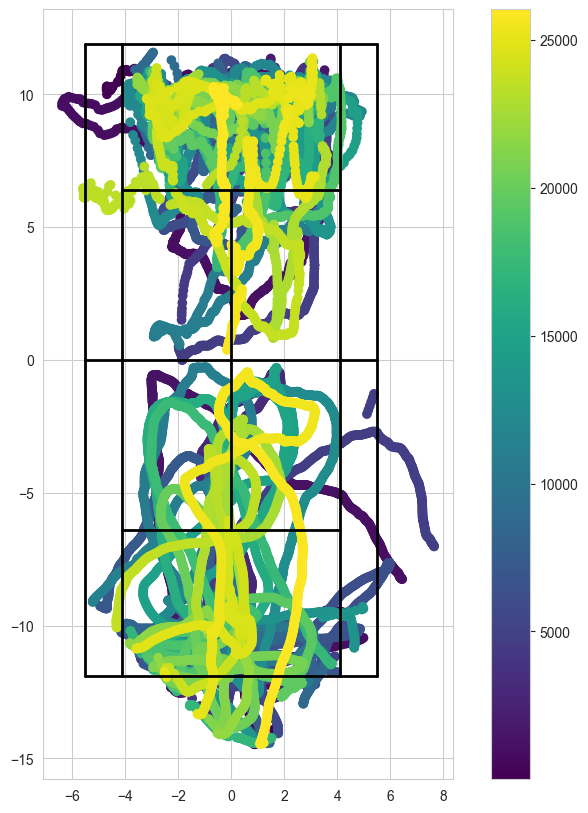

In [63]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x=cam['transformed_x'], y=cam['transformed_z'], c=cam['frame'], cmap='viridis')
drawTennisField()
plt.colorbar()
ax.set_aspect('equal')
plt.show()

# Analyse Tennisspiel

## Datawrangling

Wir schauen kurz die Daten an die von der Kamera kommen.

In [48]:
cam.head()

,frame,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,vz,width,height,length,transformed_x,transformed_y,transformed_z
0,3,0,Person,79.83398,OK,1.20102,0.41904,1.55682,-1.75535,-0.26043,0.55864,0.49680,0.57462,0.49680,1.726796,-2.344541,-13.914942
1,4,0,Person,87.45117,OK,1.15833,0.41409,1.56276,-1.56742,-0.20237,0.39540,0.49763,0.58033,0.49763,1.683944,-2.339386,-13.910451
2,5,0,Person,89.20898,OK,1.11960,0.40943,1.56608,-1.45386,-0.16676,0.29555,0.50174,0.58424,0.50174,1.645138,-2.334572,-13.908446
3,6,0,Person,90.03906,OK,1.08496,0.40524,1.56808,-1.35545,-0.14275,0.23192,0.51613,0.58824,0.51613,1.610464,-2.330259,-13.907623
4,10,2,Person,91.06445,OK,4.09950,1.25795,5.92474,-4.40850,0.16304,-1.38635,2.54048,2.63067,2.54048,4.472304,-3.122541,-9.443841


Nun schauen wir uns die Labels an, die von uns erstellt wurden.

In [49]:
labels.head()

,Frame,Status,Schlag Spieler 1,Schlag Spieler 2,Satz
0,287,Aktiv,Anschlag,NaN,1.0
1,318,NaN,NaN,Fronthand,NaN
2,372,NaN,Fronthand,NaN,NaN
3,421,NaN,NaN,Backhand,NaN
4,469,NaN,Backhand,NaN,NaN


Frame um Datensatz einzuschränken

In [50]:
max_label = labels["Frame"].max()
min_label = labels["Frame"].min()

print("Max Frame: " + str(labels["Frame"].max()))
print("Min Frame: " + str(labels["Frame"].min()))

Max Frame: 25420
Min Frame: 287


In [51]:
df = pd.merge(cam, labels, left_on="frame", right_on="Frame", how="left")
df = df.drop(columns=["Frame"])

In [52]:
df = df[ (df["frame"] >= min_label) & (df["frame"] <= max_label)]

In [53]:
df[["Status", "Satz"]] = df[["Status", "Satz"]].ffill()

In [54]:
df.head()

,frame,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,...,width,height,length,transformed_x,transformed_y,transformed_z,Status,Schlag Spieler 1,Schlag Spieler 2,Satz
521,287,3,Person,83.69141,OK,0.09633,-0.70178,5.61177,0.01540,-0.04420,...,0.64888,1.99435,0.64888,0.488342,-1.157367,-9.915421,Aktiv,Anschlag,NaN,1.0
522,287,1,Person,32.34863,OK,-2.30320,-6.71382,25.18980,-0.06328,0.04720,...,0.61570,1.17692,0.61570,-2.556822,5.167203,9.479640,Aktiv,Anschlag,NaN,1.0
523,288,3,Person,87.69531,OK,0.09590,-0.70376,5.61024,0.02580,-0.03045,...,0.66799,1.97376,0.66799,0.487970,-1.155410,-9.916995,Aktiv,NaN,NaN,1.0
524,288,1,Person,33.88672,OK,-2.30133,-6.69036,25.07622,-0.05046,0.03763,...,0.61899,1.17656,0.61899,-2.551163,5.141961,9.366557,Aktiv,NaN,NaN,1.0
525,289,3,Person,87.45117,OK,0.09519,-0.70320,5.60934,0.02339,-0.02760,...,0.68904,1.95456,0.68904,0.487290,-1.155982,-9.917908,Aktiv,NaN,NaN,1.0


In [55]:
df.pivot(index='frame', columns=['object_id'], values=['x', 'y', 'z']).head()

x                                           ...   z          \
object_id       1        3   5   6   7   8   11  12  14  15  ...  74  75  76   
frame                                                        ...               
287       -2.30320  0.09633 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   
288       -2.30133  0.09590 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   
289       -2.29745  0.09519 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   
290       -2.29753  0.08992 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   
291       -2.29808  0.08545 NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN NaN NaN   

                                       
object_id  77  78  79  80  82  83  84  
frame                                  
287       NaN NaN NaN NaN NaN NaN NaN  
288       NaN NaN NaN NaN NaN NaN NaN  
289       NaN NaN NaN NaN NaN NaN NaN  
290       NaN NaN NaN NaN NaN NaN NaN  
291       NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 165 columns]

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40927 entries, 521 to 41447
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   frame             40927 non-null  int64  
 1   object_id         40927 non-null  int64  
 2   object_label      40927 non-null  object 
 3   confidence        40927 non-null  float64
 4   tracking_state    40927 non-null  object 
 5   x                 40921 non-null  float64
 6   y                 40921 non-null  float64
 7   z                 40921 non-null  float64
 8   vx                40921 non-null  float64
 9   xy                40921 non-null  float64
 10  vz                40921 non-null  float64
 11  width             40927 non-null  float64
 12  height            40927 non-null  float64
 13  length            40927 non-null  float64
 14  transformed_x     40921 non-null  float64
 15  transformed_y     40921 non-null  float64
 16  transformed_z     40921 non-null  float64
 

In [57]:
df["object_id"] = df["object_id"].astype("category")
df["object_label"] = df["object_label"].astype("category")
df["tracking_state"] = df["tracking_state"].astype("category")

In [58]:
df.describe(include="all")

,frame,object_id,object_label,confidence,tracking_state,x,y,z,vx,xy,...,width,height,length,transformed_x,transformed_y,transformed_z,Status,Schlag Spieler 1,Schlag Spieler 2,Satz
count,40927.000000,40927.0,40927,40927.000000,40927,40921.000000,40921.000000,40921.000000,40921.000000,40921.000000,...,40927.000000,40927.000000,40927.000000,40921.000000,40921.000000,40921.000000,40927,139,116,40927.000000
unique,NaN,55.0,1,NaN,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,3,3,NaN
top,NaN,43.0,Person,NaN,OK,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Inaktiv,Anschlag,Fronthand,NaN
freq,NaN,3372.0,40927,NaN,40927,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30691,49,59,NaN
mean,12749.197693,NaN,NaN,63.723468,NaN,-0.122519,-3.334881,14.679790,0.001801,-0.002822,...,0.690503,1.575351,0.690503,-0.030549,1.618146,-0.901187,NaN,NaN,NaN,2.376964
std,7284.000623,NaN,NaN,25.954921,NaN,2.082710,2.758861,9.094114,0.705281,0.264532,...,0.127199,0.236615,0.127199,2.052488,2.900201,9.056809,NaN,NaN,NaN,0.858455
min,287.000000,NaN,NaN,20.056150,NaN,-6.107420,-7.289750,1.055340,-11.140330,-4.515370,...,0.000000,0.000000,0.000000,-6.365507,-3.132264,-14.431531,NaN,NaN,NaN,1.000000
25%,6424.000000,NaN,NaN,36.743160,NaN,-1.749370,-6.400770,5.376850,-0.309650,-0.148990,...,0.611500,1.381120,0.611500,-1.584852,-1.311246,-10.170885,NaN,NaN,NaN,1.000000
50%,12779.000000,NaN,NaN,77.929690,NaN,-0.281750,-2.778260,12.805230,0.011770,-0.008040,...,0.668100,1.656850,0.668100,-0.120740,1.032182,-2.739774,NaN,NaN,NaN,3.000000
75%,18874.500000,NaN,NaN,87.109380,NaN,1.423310,-0.549400,24.772980,0.293260,0.139230,...,0.739995,1.768190,0.739990,1.374809,4.841877,9.124562,NaN,NaN,NaN,3.000000


- object_id scheint zu viele unterschiedliche labels zu haben.
- confidence scheint muss noch genauer untersucht werden, da die Werte teilweise etwas tief sind